<CENTER><img src="../images/ATLASOD.gif" style="width:50%"></CENTER>

# <CENTER><h1> Analysis of $H \rightarrow ZZ$ process. Rediscovering the Higgs boson by yourself</h1></CENTER>

## Simple pyROOT notebook example
In this notebook you can find an easy set of commands that show the basic computing techniques commonly used in high energy  physics (HEP) analysis. It also shows how to create a histogram, fills it, draws it and uses a fit function on it. Moreover it is an introduction to [ROOT](https://root.cern.ch/) too. At the end you will get a plot with the invariant mass of the four leptons system, which represents the invariant mass of the Z boson.</p>

The Analysis is implemented by using some useful tools, such as pandas (to storage dataframes), numpy (the numerical library of python), uproot3 (to read root files), matplotlib (to plot our graphics) and math library (an additional library in python that allows you to use numerical functions).

First at all, we should verify that we have installed all need tools to perform our analysis. If we haven't, we can run the next code line:

In [1]:
"""
import sys
!{sys.executable} -m pip install --upgrade --user pip # update the pip package installer
!{sys.executable} -m pip install -U numpy pandas uproot3 matplotlib sklearn tensorflow keras --user # install required packages
"""

'\nimport sys\n!{sys.executable} -m pip install --upgrade --user pip # update the pip package installer\n!{sys.executable} -m pip install -U numpy pandas uproot3 matplotlib sklearn tensorflow keras --user # install required packages\n'

In [2]:
"""
import sys
!{sys.executable} -m pip install --upgrade --user pip # update the pip package installer
!{sys.executable} -m pip install -U keras --user # install required packages
"""

'\nimport sys\n!{sys.executable} -m pip install --upgrade --user pip # update the pip package installer\n!{sys.executable} -m pip install -U keras --user # install required packages\n'

Now, we can import the tools that we are going to use (pandas, numpy, matplotlib, etc):

In [3]:
import pandas as pd # to store data as dataframes
import numpy as np # for numerical calculations such as histogramming
import math # for mathematical functions such as square root
import uproot3 # to read .root files as dataframes
import time # to measure time to analyse
import matplotlib.pyplot as plt # for plotting
from matplotlib.ticker import AutoMinorLocator # for minor ticks
import infofile # local file containing info on cross-sections, sums of weights, dataset IDs

/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/uproot3/__init__.py:127: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


The root files which contain the events information is storaged in [4lep folder](https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/4lep/). So we are going to define the "path_file" variable which contains the url of the folder uploaded in the ATLAS Open Data repository on the cloud. The next code line also defines a variable named "lumi", which represents the luminosity and it is equal to 10 $fb^{-1}$. If we want to run the analysis over a fraction of the whole data and MC samples, we can define another variable named "fraction", which will be defined equal to 1.0 as default. However, you can change this fraction value and see how this can affect the final result shown in the final plot:

In [4]:
lumi = 10 # fb-1 # data_A,data_B,data_C,data_D

fraction = 1.0 # reduce this is if you want the code to run quicker
                                                                                                                                  
#tuple_path = "Input/4lep/" ## for local folder, but you have to download all root files used in this analysis 
tuple_path = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/4lep/" # web address

Now, we are going to make a list named "samples". In this samples list we are going to include data and background samples (including the signal we want to observe). In the next code line we can see all samples that are going to be used in the analysis and to what group they belong. If you want to add more samples, consider modify this code line too. 

In [5]:
samples = {

    'data': {
        'list' : ['data_A','data_B','data_C','data_D'],
    },

    r'Background $Z,t\bar{t}$' : { # Z + ttbar
        'list' : ['Zee','Zmumu','ttbar_lep'],
        'color' : "#6b59d3" # purple
    },

    r'Background $ZZ^*$' : { # ZZ
        'list' : ['llll'],
        'color' : "#ff0000" # red
    },
    
    
    r'Signal ($m_H$ = 125 GeV)' : { # H -> ZZ -> llll
        'list' : ['ggH125_ZZ4lep','VBFH125_ZZ4lep','WH125_ZZ4lep','ZH125_ZZ4lep'],
        'color' : "#00cdff" # light blue
    },
}

The next function named "get data from files" returns the events from data and MC samples that passed the selection criteria once we have applied all cuts. First, the function makes a for loop in the "samples" list and separates data from background in order to define an adequate path to open the root files. Then, it defines a temporary dataframe in which we save the events passing the criteria selection for each sample. Finally, it adds these temporary dataframes into a dictionary (named "data" in the code line) for each sample group and returns this data dictionary with the information of all the events considered in the analysis that passed the criteria selection. At the end, this function gives us the whole events information we need to create our final plot.

In [6]:
def get_data_from_files():

    data = {} # define empty dictionary to hold dataframes
    for s in samples: # loop over samples
        print('Processing '+s+' samples') # print which sample
        frames = [] # define empty list to hold data
        for val in samples[s]['list']: # loop over each file
            if s == 'data': prefix = "Data/" # Data prefix
            else: # MC prefix
                prefix = "MC/mc_"+str(infofile.infos[val]["DSID"])+"."
            fileString = tuple_path+prefix+val+".4lep.root" # file name to open
            temp = read_file(fileString,val) # call the function read_file defined below
            frames.append(temp) # append dataframe returned from read_file to list of dataframes
        data[s] = pd.concat(frames, ignore_index = True) # dictionary entry is concatenated dataframes
    
    return data # return dictionary of dataframes

The "calc_weight" function calculates the total weight for each event taking into account the weight associated with the cross section and the efficiency of the detectors, the scale factors that consider the PILE UP and leptons triggers and the weight given by the algorithms used to create the MC samples. This function is only applied for MC samples and not for data.

In [7]:
def calc_weight(xsec_weight, mcWeight, scaleFactor_PILEUP,
                scaleFactor_ELE, scaleFactor_MUON, 
                scaleFactor_LepTRIGGER ):
    return (xsec_weight*mcWeight*scaleFactor_PILEUP*scaleFactor_ELE*scaleFactor_MUON*scaleFactor_LepTRIGGER)

Now, we define a function that computes the factor weight due to the information in the infofile.py file. This function uses the event weight due to efficiency of the calorimeters, the sum of weights for MC and the cross section for samples. Of course, the data samples are not needed to be scaled, this only apply for MC samples:

In [8]:
def get_xsec_weight(sample):
    info = infofile.infos[sample] # open infofile
    xsec_weight = (lumi*1000*info["xsec"])/(info["sumw"]*info["red_eff"]) #*1000 to go from fb-1 to pb-1
    return xsec_weight # return cross-section weight

The function that computes the mass of the four lepton system is defined below. It is needed the pT, $\eta$, $\phi$ and the energy of each lepton in order to get the invariant mass.

In [9]:
def calc_mllll(lep_pt, lep_eta, lep_phi, lep_E):
    # first lepton is [0], 2nd lepton is [1] etc
    px_0 = lep_pt[0]*math.cos(lep_phi[0]) # x-component of lepton[0] momentum
    py_0 = lep_pt[0]*math.sin(lep_phi[0]) # y-component of lepton[0] momentum
    pz_0 = lep_pt[0]*math.sinh(lep_eta[0]) # z-component of lepton[0] momentum
    px_1 = lep_pt[1]*math.cos(lep_phi[1]) # x-component of lepton[1] momentum
    py_1 = lep_pt[1]*math.sin(lep_phi[1]) # y-component of lepton[1] momentum
    pz_1 = lep_pt[1]*math.sinh(lep_eta[1]) # z-component of lepton[1] momentum
    px_2 = lep_pt[2]*math.cos(lep_phi[2]) # x-component of lepton[2] momentum
    py_2 = lep_pt[2]*math.sin(lep_phi[2]) # y-component of lepton[2] momentum
    pz_2 = lep_pt[2]*math.sinh(lep_eta[2]) # z-component of lepton[2] momentum
    px_3 = lep_pt[3]*math.cos(lep_phi[3]) # x-component of lepton[3] momentum
    py_3 = lep_pt[3]*math.sin(lep_phi[3]) # y-component of lepton[3] momentum
    pz_3 = lep_pt[3]*math.sinh(lep_eta[3]) # z-component of lepton[3] momentum    
    sumpx = px_0 + px_1 + px_2 + px_3 # x-component of momentum
    sumpy = py_0 + py_1 + py_2 + py_3 # y-component of momentum
    sumpz = pz_0 + pz_1 + pz_2 + pz_3 # z-component of momentum 
    sump = math.sqrt(sumpx**2 + sumpy**2 + sumpz**2) # magnitude of momentum 
    sumE = lep_E[0] + lep_E[1] + lep_E[2] + lep_E[3] # energy of dilepton system
    return math.sqrt(sumE**2 - sump**2)/1000 #/1000 to go from MeV to GeV

## Changing a cut

For this analysis, we only apply two main cuts. These cuts are going to be defined as follow:

### Lepton charge cut

This cut selects events in which the sum of the four lepton's charge is equal to zero. This is because the Z boson has an electric charge equal to zero and therefore, Z boson decays into two leptons of opposite charges. The events that fulfill this requirements returns True.

In [10]:
def cut_lep_charge(lep_charge):     
    return lep_charge[0] + lep_charge[1] + lep_charge[2] + lep_charge[3] == 0

### Lepton type cut

This cut needs the lepton type of each lepton, because we want to choose events that have two pairs of electrons, two pairs of muons or one pair of electrons and one pair of muons in the final state. If the event doesn't fulfill this requirement, the event is dropped.

In [11]:
def cut_lep_type(lep_type):
    sum_lep_type = lep_type[0] + lep_type[1] + lep_type[2] + lep_type[3]
    return (sum_lep_type == 44) or (sum_lep_type == 48) or (sum_lep_type == 52)

## Applying a cut

In [12]:
def calc_lep_pt_i(lep_pt,i):
    return lep_pt[i]/1000 # /1000 to go from MeV to GeV

Now, we can define a function that applies all cuts and the criteria selection. For this reason, we create a function named "read_file" that receives a string path and the name of the sample we want to analyze. In this function we print the number of initial events and the number of events that passed the cuts. We also compute the invariant mass of the four lepton system and save it in a column into the dataframe which contains all the selected events for each batch. At the end, it returns a dataframe with the selected events for the sample given as an argument of the function. 

In [13]:
def read_file(path,sample):
    start = time.time() # start the clock
    print("\tProcessing: "+sample) # print which sample is being processed
    data_all = pd.DataFrame() # define empty pandas DataFrame to hold all data for this sample
    tree = uproot3.open(path)["mini"] # open the tree called mini
    numevents = uproot3.numentries(path, "mini") # number of events
    if 'data' not in sample: xsec_weight = get_xsec_weight(sample) # get cross-section weight
    for data in tree.iterate(['lep_charge','lep_type','lep_pt',
                              'lep_eta','lep_phi','lep_E', 
                              'mcWeight','scaleFactor_PILEUP',
                              'scaleFactor_ELE','scaleFactor_MUON',
                              'scaleFactor_LepTRIGGER'], # variables to calculate Monte Carlo weight
                             outputtype=pd.DataFrame, # choose output type as pandas DataFrame
                             entrystop=numevents*fraction): # process up to numevents*fraction

        nIn = len(data.index) # number of events in this batch
    
        if 'data' not in sample: # only do this for Monte Carlo simulation files
            # multiply all Monte Carlo weights and scale factors together to give total weight
        
            data['totalWeight'] = np.vectorize(calc_weight)(xsec_weight,
                                                            data.mcWeight,
                                                            data.scaleFactor_PILEUP,
                                                            data.scaleFactor_ELE,
                                                            data.scaleFactor_MUON,
                                                            data.scaleFactor_LepTRIGGER)

        # cut on lepton charge using the function cut_lep_charge defined above
        data = data[ np.vectorize(cut_lep_charge)(data.lep_charge)]
        
        # cut on lepton type using the function cut_lep_type defined above
        data = data[ np.vectorize(cut_lep_type)(data.lep_type)]        
        
        # calculation of 4-lepton invariant mass using the function calc_mllll defined above
        data['mllll'] = np.vectorize(calc_mllll)(data.lep_pt,data.lep_eta,data.lep_phi,data.lep_E)
        
        data['lep_pt_1'] = np.vectorize(calc_lep_pt_i)(data.lep_pt, 0)
        data['lep_pt_2'] = np.vectorize(calc_lep_pt_i)(data.lep_pt, 1)        
      
        nOut = len(data.index) # number of events passing cuts in this batch
        # append dataframe from this batch to the dataframe for the whole sample
        data_all = data_all.append(data, ignore_index = True) 

        elapsed = time.time() - start # time taken to process
        print("\t\t nIn: "+str(nIn)+",\t nOut: \t"+str(nOut)+"\t in "+str(round(elapsed,1))+"s") # events before and after
        
    return data_all # return dataframe containing events passing all cuts

Now, we are ready to perform the analysis. Just run the next line code if you want to save the complete selected events for all samples in a dictionary of dataframe called "data". We will use this dictionary of dataframes to plot our final graph. 

In [14]:
start = time.time() # time at start of whole processing
data = get_data_from_files() # process all files
elapsed = time.time() - start # time after whole processing
print("Time taken: "+str(round(elapsed,1))+"s") # print total time taken to process every file

Processing data samples
	Processing: data_A
		 nIn: 39,	 nOut: 	27	 in 3.7s
	Processing: data_B
		 nIn: 156,	 nOut: 	86	 in 0.2s
	Processing: data_C
		 nIn: 237,	 nOut: 	146	 in 0.7s
	Processing: data_D
		 nIn: 400,	 nOut: 	248	 in 0.4s
Processing Background $Z,t\bar{t}$ samples
	Processing: Zee
		 nIn: 898,	 nOut: 	243	 in 0.5s
	Processing: Zmumu
		 nIn: 684,	 nOut: 	257	 in 0.4s
	Processing: ttbar_lep
		 nIn: 1031,	 nOut: 	334	 in 0.8s
Processing Background $ZZ^*$ samples
	Processing: llll
		 nIn: 106415,	 nOut: 	100522	 in 19.6s
		 nIn: 106415,	 nOut: 	100595	 in 28.3s
		 nIn: 106415,	 nOut: 	100580	 in 37.3s
		 nIn: 106415,	 nOut: 	100618	 in 46.1s
		 nIn: 106415,	 nOut: 	100655	 in 54.8s
		 nIn: 22204,	 nOut: 	20987	 in 56.8s
Processing Signal ($m_H$ = 125 GeV) samples
	Processing: ggH125_ZZ4lep
		 nIn: 104555,	 nOut: 	102484	 in 36.1s
		 nIn: 60161,	 nOut: 	58967	 in 40.6s
	Processing: VBFH125_ZZ4lep
		 nIn: 102038,	 nOut: 	99807	 in 28.6s
		 nIn: 89088,	 nOut: 	87063	 in 37.5s
	

In [15]:
data

{'data':          lep_charge          lep_type  \
 0    [-1, 1, -1, 1]  [11, 13, 13, 11]   
 1    [-1, 1, -1, 1]  [11, 11, 13, 13]   
 2    [1, 1, -1, -1]  [11, 11, 11, 11]   
 3    [-1, -1, 1, 1]  [13, 11, 11, 13]   
 4    [1, -1, -1, 1]  [11, 11, 13, 13]   
 ..              ...               ...   
 502  [-1, 1, 1, -1]  [11, 11, 11, 11]   
 503  [1, -1, -1, 1]  [13, 13, 13, 13]   
 504  [-1, 1, 1, -1]  [13, 13, 13, 13]   
 505  [1, 1, -1, -1]  [11, 11, 11, 11]   
 506  [1, 1, -1, -1]  [11, 13, 13, 11]   
 
                                           lep_pt  \
 0    [175558.73, 138846.67, 106696.53, 79776.73]   
 1    [65284.066, 37290.766, 12426.926, 8804.564]   
 2     [146784.7, 127539.97, 33562.18, 29776.129]   
 3     [135680.69, 82894.8, 62508.098, 42552.906]   
 4    [67713.18, 42791.816, 12742.542, 10291.093]   
 ..                                           ...   
 502  [51773.375, 51708.45, 51148.297, 30737.582]   
 503  [61561.816, 25231.277, 21982.31, 14411.031]   
 504  [53

Finally, we define a function that plots our final graphic. This function receives the data dictionary with the information of all selected events in our analysis and create histograms for each dataframe (which are the main sources of background, the signal and the data). The final plot is saved in a pdf file into the folder called "plots".

In [16]:
def plot_data(data):
    GeV = 1.0
    xmin = 80 * GeV
    xmax = 250 * GeV
    step_size = 5 * GeV

    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    data_x,_ = np.histogram(data['data']['mllll'], 
                            bins=bin_edges ) # histogram the data
    data_x_errors = np.sqrt( data_x ) # statistical error on the data

    signal_x = data[r'Signal ($m_H$ = 125 GeV)']['mllll'] # histogram the signal
    signal_weights = data[r'Signal ($m_H$ = 125 GeV)'].totalWeight # get the weights of the signal events
    signal_color = samples[r'Signal ($m_H$ = 125 GeV)']['color'] # get the colour for the signal bar

    mc_x = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

    for s in samples: # loop over samples
        if s not in ['data', r'Signal ($m_H$ = 125 GeV)']: # if not data nor signal
            mc_x.append( data[s]['mllll'] ) # append to the list of Monte Carlo histogram entries
            mc_weights.append( data[s].totalWeight ) # append to the list of Monte Carlo weights
            mc_colors.append( samples[s]['color'] ) # append to the list of Monte Carlo bar colors
            mc_labels.append( s ) # append to the list of Monte Carlo legend labels
    


    # *************
    # Main plot 
    # *************
    main_axes = plt.gca() # get current axes
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors,
                      fmt='ko', # 'k' means black and 'o' is for circles 
                      label='Data') 
    
    # plot the Monte Carlo bars
    mc_heights = main_axes.hist(mc_x, bins=bin_edges, 
                                weights=mc_weights, stacked=True, 
                                color=mc_colors, label=mc_labels )
    
    mc_x_tot = mc_heights[0][-1] # stacked background MC y-axis value
    
    # calculate MC statistical uncertainty: sqrt(sum w^2)
    mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])
    
    # plot the signal bar
    main_axes.hist(signal_x, bins=bin_edges, bottom=mc_x_tot, 
                   weights=signal_weights, color=signal_color,
                   label=r'Signal ($m_H$ = 125 GeV)')
    
    # plot the statistical uncertainty
    main_axes.bar(bin_centres, # x
                  2*mc_x_err, # heights
                  alpha=0.5, # half transparency
                  bottom=mc_x_tot-mc_x_err, color='none', 
                  hatch="////", width=step_size, label='Stat. Unc.' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=True, # draw ticks on the top axis
                          right=True ) # draw ticks on right axis
    
    # x-axis label
    main_axes.set_xlabel(r'4-lepton invariant mass $\mathrm{m_{4l}}$ [GeV]',
                        fontsize=13, x=1, horizontalalignment='right' )
    
    # write y-axis label for main axes
    main_axes.set_ylabel('Events / '+str(step_size)+' GeV',
                         y=1, horizontalalignment='right') 
    
    # set y-axis limits for main axes
    main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.6 )
    
    # add minor ticks on y-axis for main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.05, # x
             0.93, # y
             'ATLAS Open Data', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 
    
    # Add text 'for education' on plot
    plt.text(0.05, # x
             0.88, # y
             'for education', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=8 ) 
    
    # Add energy and luminosity
    lumi_used = str(lumi*fraction) # luminosity to write on the plot
    plt.text(0.05, # x
             0.82, # y
             '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes
    
    # Add a label for the analysis carried out
    plt.text(0.05, # x
             0.76, # y
             r'$H \rightarrow ZZ^* \rightarrow 4\ell$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # draw the legend
    main_axes.legend( frameon=False ) # no box around the legend
    plt.savefig('plots/HZZ_m4L.pdf')
    return

Run the next line code if you want to see the final plot with the invariant mass of the Z boson.

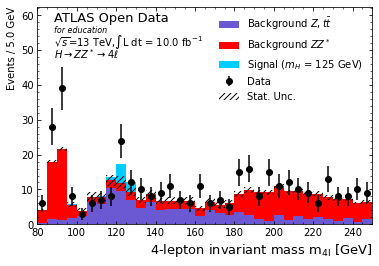

In [17]:
plot_data(data)

In [18]:
mllll = { # dictionary containing plotting parameters for the lep_pt_2 histogram
    # change plotting parameters
    'bin_width':5, # width of each histogram bin
    'num_bins':32, # number of histogram bins
    'xrange_min':80, # minimum on x-axis
    'xlabel':r'4-lepton invariant mass $\mathrm{m_{4l}}$ [GeV]', # x-axis label
}

lep_pt_1 = { # dictionary containing plotting parameters for the lep_pt_1 histogram
    # change plotting parameters
    'bin_width':5, # width of each histogram bin
    'num_bins':28, # number of histogram bins
    'xrange_min':25, # minimum on x-axis
    'xlabel':r'$lep\_pt$[1] [GeV]', # x-axis label
}


SoverB_hist_dict = {'mllll':mllll, 'lep_pt_1':lep_pt_1} 
# add a histogram here if you want it plotted

In [19]:
def plot_SoverB(data):
    
    signal = r'Signal ($m_H$ = 125 GeV)' # which sample is the signal

    # *******************
    # general definitions (shouldn't need to change)

    for x_variable,hist in SoverB_hist_dict.items(): # access the dictionary of histograms defined in the cell above

        h_bin_width = hist['bin_width'] # get the bin width defined in the cell above
        h_num_bins = hist['num_bins'] # get the number of bins defined in the cell above
        h_xrange_min = hist['xrange_min'] # get the x-range minimum defined in the cell above
        h_xlabel = hist['xlabel'] # get the x-axis label defined in the cell above
    
        bin_edges = [ h_xrange_min + x*h_bin_width for x in range(h_num_bins+1) ] # bin limits
        bin_centres = [ h_xrange_min+h_bin_width/2 + x*h_bin_width for x in range(h_num_bins) ] # bin centres
        
        signal_x = data[signal][x_variable] # histogram the signal
    
        mc_x = [] # define list to hold the Monte Carlo histogram entries

        for s in samples: # loop over samples
            if s not in ['data', signal]: # if not data nor signal
                mc_x = [*mc_x, *data[s][x_variable] ] # append to the list of Monte Carlo histogram entries

    
    
        # *************
        # Signal and background distributions
        # *************
        distributions_axes = plt.gca() # get current axes
 
        mc_heights = distributions_axes.hist(mc_x, bins=bin_edges, color='red', 
                                             label='Total background',
                                             histtype='step', # lineplot that's unfilled
                                             density=True ) # normalize to form probability density
        signal_heights = distributions_axes.hist(signal_x, bins=bin_edges, color='blue',
                                                 label=signal, 
                                                 histtype='step', # lineplot that's unfilled
                                                 density=True, # normalize to form probability density
                                                 linestyle='--' ) # dashed line
        
        distributions_axes.set_xlim( left=bin_edges[0], right=bin_edges[-1] ) # x-limits of the distributions axes
        distributions_axes.set_ylabel('Arbitrary units' ) # y-axis label for distributions axes
        distributions_axes.set_ylim( top=max(signal_heights[0])*1.5 ) # set y-axis limits
        plt.title('Signal and background '+x_variable+' distributions') # add title
        distributions_axes.legend() # draw the legend
        distributions_axes.set_xlabel( h_xlabel ) # x-axis label
        
        # Add text 'ATLAS Open Data' on plot
        plt.text(0.05, # x
                 0.93, # y
                 'ATLAS Open Data', # text
                 transform=distributions_axes.transAxes, # coordinate system used is that of distributions_axes
                 fontsize=13 ) 
        # Add text 'for education' on plot
        plt.text(0.05, # x
                 0.88, # y
                 'for education', # text
                 transform=distributions_axes.transAxes, # coordinate system used is that of distributions_axes
                 style='italic',
                 fontsize=8 )  
        plt.savefig('plots/HZZ_distribution_'+x_variable+'.pdf')
        plt.show() # show the Signal and background distributions
        
    
        # *************
        # Signal to background ratio
        # *************
        plt.figure() # start new figure
        SoverB = [] # list to hold S/B values
        for cut_value in bin_edges: # loop over bins
            signal_weights_passing_cut = sum(data[signal][data[signal][x_variable]>cut_value].totalWeight)
            background_weights_passing_cut = 0 # start counter for background weights passing cut
            for s in samples: # loop over samples
                if s not in ['data', signal]: # if not data nor signal
                    background_weights_passing_cut += sum(data[s][data[s][x_variable]>cut_value].totalWeight)
            if background_weights_passing_cut!=0: # some background passes cut
                SoverB_value = signal_weights_passing_cut/background_weights_passing_cut
                SoverB_percent = 100*SoverB_value # multiply by 100 for percentage
                SoverB.append(SoverB_percent) # append to list of S/B values
        
        SoverB_axes = plt.gca() # get current axes
        SoverB_axes.plot( bin_edges[:len(SoverB)], SoverB ) # plot the data points
        SoverB_axes.set_xlim( left=bin_edges[0], right=bin_edges[-1] ) # set the x-limit of the main axes
        SoverB_axes.set_ylabel( 'S/B (%)' ) # write y-axis label for main axes
        plt.title('Signal to background ratio for different '+x_variable+' cut values', family='sans-serif')
        SoverB_axes.set_xlabel( h_xlabel ) # x-axis label 
        plt.savefig('plots/HZZ_SoverB_'+x_variable+'.pdf')
        plt.show() # show S/B plot
        
    
    return

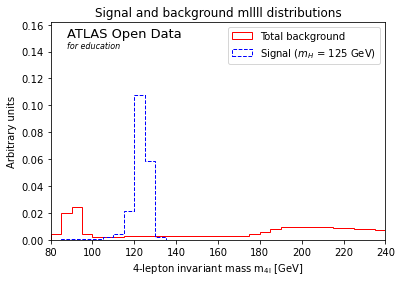

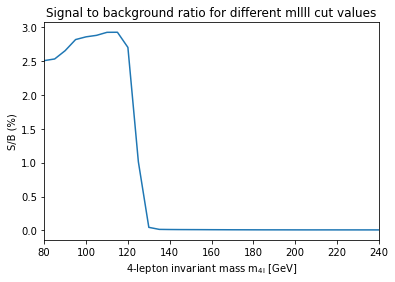

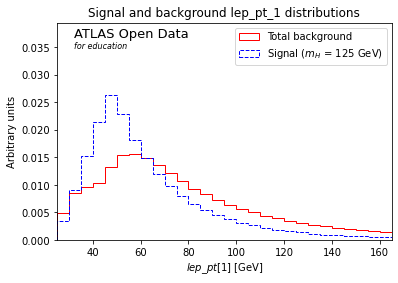

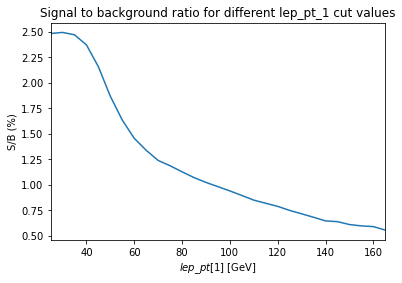

In [20]:
plot_SoverB(data)

In [21]:
data_for_BDT = {} # define empty dictionary to hold dataframes that will be used to train the BDT
BDT_inputs = ['mllll', 'lep_pt_1'] # list of features for BDT
for key in data: # loop over the different keys in the dictionary of dataframes
    data_for_BDT[key] = data[key][BDT_inputs].copy()
data_for_BDT

{'data':           mllll    lep_pt_1
 0    649.271931  175.558734
 1     87.907098   65.284066
 2    344.775936  146.784703
 3    326.583790  135.680688
 4    107.422585   67.713180
 ..          ...         ...
 502  209.585334   51.773375
 503  121.270402   61.561816
 504  149.033446   53.048145
 505  318.595413  114.072234
 506  305.914725   88.545625
 
 [507 rows x 2 columns],
 'Background $Z,t\\bar{t}$':           mllll    lep_pt_1
 0    123.778564   39.319230
 1    162.560351   47.592391
 2    219.564061   51.710316
 3    157.108745   65.519844
 4    106.592748   39.427957
 ..          ...         ...
 829  221.392648  108.052734
 830   89.324171   72.671664
 831  271.143367  108.584250
 832  251.470387   57.052246
 833  191.160258   47.612863
 
 [834 rows x 2 columns],
 'Background $ZZ^*$':              mllll    lep_pt_1
 0       229.654277   64.853691
 1       132.688869   55.921848
 2       296.506040   84.155969
 3       101.265195  100.780219
 4       623.674832  172.537703
 

In [22]:
# for sklearn data is usually organised                                                                                                                                           
# into one 2D array of shape (n_samples x n_features)                                                                                                                             
# containing all the data and one array of categories                                                                                                                             
# of length n_samples  

all_MC = [] # define empty list that will contain all features for the MC
for key in data: # loop over the different keys in the dictionary of dataframes
    if key!='data': # only MC should pass this
        all_MC.append(data_for_BDT[key]) # append the MC dataframe to the list containing all MC features
X = np.concatenate(all_MC) # concatenate the list of MC dataframes into a single 2D array of features, called X

all_y = [] # define empty list that will contain labels whether an event in signal or background
for key in data: # loop over the different keys in the dictionary of dataframes
    if key!=r'Signal ($m_H$ = 125 GeV)' and key!='data': # only background MC should pass this
        all_y.append(np.zeros(data_for_BDT[key].shape[0])) # background events are labelled with 0
all_y.append(np.ones(data_for_BDT[r'Signal ($m_H$ = 125 GeV)'].shape[0])) # signal events are labelled with 1
y = np.concatenate(all_y) # concatenate the list of lables into a single 1D array of labels, called y

In [23]:
from sklearn.model_selection import train_test_split

# make train and test sets
X_train,X_test, y_train,y_test = train_test_split(X, y, test_size=0.7, random_state=492 )

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

dt = DecisionTreeClassifier(max_depth=2) # maximum depth of the tree
bdt = AdaBoostClassifier(dt,
                        algorithm='SAMME', # SAMME discrete boosting algorithm
                        n_estimators=12, # max number of estimators at which boosting is terminated
                        learning_rate=0.5) # shrinks the contribution of each classifier by learning_rate

start = time.time() # time at start of BDT fit
bdt.fit(X_train, y_train) # fit BDT to training set
elapsed = time.time() - start # time after fitting BDT
print("Time taken to fit BDT: "+str(round(elapsed,1))+"s") # print total time taken to fit BDT
print(bdt)

Time taken to fit BDT: 3.7s
AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=0.5, n_estimators=12)


In [25]:
from sklearn.metrics import classification_report, roc_auc_score, f1_score

y_predicted = bdt.predict(X_test) # get predicted y for test set
#sklearn.metrics.f1_score(y_test, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')
#f1_score(y_test, y_predicted, zero_division=1)
        
print (classification_report(y_test, y_predicted,
                            target_names=["background", "signal"]))
print ("Area under ROC curve for test data: %.4f"%(roc_auc_score(y_test,
                                                    bdt.decision_function(X_test))) )
y_predicted

              precision    recall  f1-score   support

  background       0.98      0.96      0.97    367498
      signal       0.95      0.98      0.96    258884

    accuracy                           0.97    626382
   macro avg       0.96      0.97      0.97    626382
weighted avg       0.97      0.97      0.97    626382

Area under ROC curve for test data: 0.9863


array([1., 0., 0., ..., 0., 1., 0.])

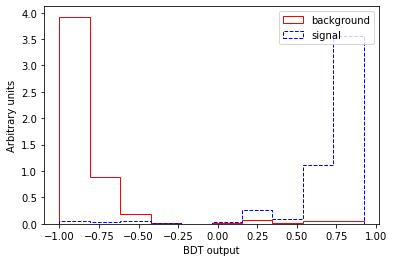

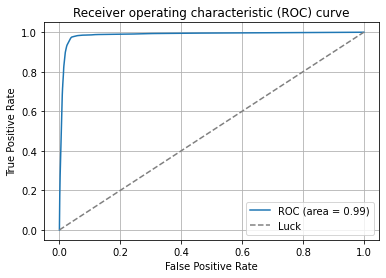

In [26]:
# we first plot the Neural Network output
signal_decisions = bdt.decision_function(X[y>0.5]).ravel() # get probabilities on signal
background_decisions = bdt.decision_function(X[y<0.5]).ravel() # get decisions on background

plt.hist(background_decisions, color='red', label='background', 
         histtype='step', # lineplot that's unfilled
         density=True ) # normalize to form a probability density
plt.hist(signal_decisions, color='blue', label='signal', 
         histtype='step', # lineplot that's unfilled
         density=True, # normalize to form a probability density
         linestyle='--' ) # dashed line
plt.xlabel('BDT output') # add x-axis label
plt.ylabel('Arbitrary units') # add y-axis label
plt.savefig('plots/HZZ_BDT_distribution.pdf')
plt.legend() # add legend


# we then plot the ROC
plt.figure() # make new figure 

from sklearn.metrics import roc_curve, auc

decisions = bdt.decision_function(X_test).ravel() # get probabilities on test set

# Compute ROC curve and area under the curve
fpr, tpr, _ = roc_curve(y_test, # actual
                        decisions ) # predicted

# Compute area under the curve for training set
roc_auc = auc(fpr, # false positive rate 
              tpr) # true positive rate

plt.plot(fpr, tpr, label='ROC (area = %0.2f)'%(roc_auc)) # plot test ROC curve
plt.plot([0, 1], # x from 0 to 1
         [0, 1], # y from 0 to 1
         '--', # dashed line
         color='grey', label='Luck')

plt.xlabel('False Positive Rate') # x-axis label
plt.ylabel('True Positive Rate') # y-axis label
plt.title('Receiver operating characteristic (ROC) curve') # title
plt.legend() # add legend
plt.grid() # add grid
plt.savefig('plots/HZZ_ROC_BDT.pdf')

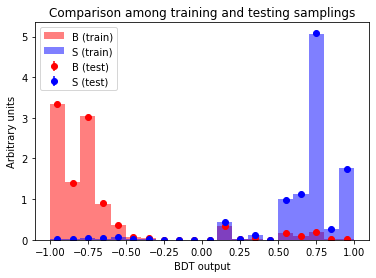

In [27]:
def compare_train_test(clf, X_train, y_train, X_test, y_test):
    decisions = [] # list to hold decisions of classifier
    for X,y in ((X_train, y_train), (X_test, y_test)): # train and test
        d1 = clf.decision_function(X[y<0.5]).ravel() # background
        d2 = clf.decision_function(X[y>0.5]).ravel() # signal
        decisions += [d1, d2] # add to list of classifier decision
    
    highest_decision = max(np.max(d) for d in decisions) # get maximum score
    bin_edges = [] # list to hold bin edges
    bin_edge = -1.1 # start counter for bin_edges
    while bin_edge < highest_decision: # up to highest score
        bin_edge += 0.1 # increment
        bin_edges.append(bin_edge)
    
    plt.hist(decisions[0], # background in train set
             bins=bin_edges, # lower and upper range of the bins
             density=True, # area under the histogram will sum to 1
             histtype='stepfilled', # lineplot that's filled
             color='red', label='B (train)', # Background (train)
            alpha=0.5 ) # half transparency
    plt.hist(decisions[1], # background in train set
             bins=bin_edges, # lower and upper range of the bins
             density=True, # area under the histogram will sum to 1
             histtype='stepfilled', # lineplot that's filled
             color='blue', label='S (train)', # Signal (train)
            alpha=0.5 ) # half transparency

    hist_background, bin_edges = np.histogram(decisions[2], # background test
                                              bins=bin_edges, # number of bins in function definition
                                              density=True ) # area under the histogram will sum to 1
    
    scale = len(decisions[2]) / sum(hist_background) # between raw and normalised
    err_background = np.sqrt(hist_background * scale) / scale # error on test background

    width = 0.1 # histogram bin width
    center = (bin_edges[:-1] + bin_edges[1:]) / 2 # bin centres
    
    plt.errorbar(x=center, y=hist_background, yerr=err_background, fmt='o', # circles
                 c='red', label='B (test)' ) # Background (test)
    
    hist_signal, bin_edges = np.histogram(decisions[3], # siganl test
                                          bins=bin_edges, # number of bins in function definition
                                          density=True ) # area under the histogram will sum to 1
    scale = len(decisions[3]) / sum(hist_signal) # between raw and normalised
    err_signal = np.sqrt(hist_signal * scale) / scale # error on test background
    
    plt.errorbar(x=center, y=hist_signal, yerr=err_signal, fmt='o', # circles
                 c='blue', label='S (test)' ) # Signal (test)
    
    plt.xlabel("BDT output") # write x-axis label
    plt.ylabel("Arbitrary units") # write y-axis label
    plt.legend() # add legend
    plt.title("Comparison among training and testing samplings")
    plt.savefig('plots/HZZ_BDT_compare_train_test.pdf')
    
compare_train_test(bdt, X_train, y_train, X_test, y_test) # call compare_train_test

In [28]:
# X only has only the MC features
y_predicted = bdt.decision_function(X) 
y_predicted

array([ 0.76522695, -0.84510817, -1.        , ...,  0.10654751,
        0.1403196 ,  0.15935064])

In [29]:
cumulative_events = 0 # start counter for total number of events for which output is saved
for key in data: # loop over samples
    if key!='data':
        data[key]['BDT_output'] = y_predicted[cumulative_events:cumulative_events+len(data[key])]
        cumulative_events += len(data[key]) # increment counter for total number of events
        print(data[key]['BDT_output']) # print the dataframe column BDT_output

0      0.765227
1     -0.845108
2     -1.000000
3     -0.811336
4      0.159351
         ...   
829   -0.966228
830   -0.633515
831   -1.000000
832   -1.000000
833   -1.000000
Name: BDT_output, Length: 834, dtype: float64
0        -0.966228
1        -0.608507
2        -1.000000
3        -0.396913
4        -1.000000
            ...   
523952   -1.000000
523953   -1.000000
523954   -1.000000
523955   -0.845108
523956    0.318141
Name: BDT_output, Length: 523957, dtype: float64
0         0.765227
1         0.159351
2         0.765227
3         0.924017
4         0.924017
            ...   
370035    0.765227
370036    0.924017
370037    0.106548
370038    0.140320
370039    0.159351
Name: BDT_output, Length: 370040, dtype: float64


In [30]:
bin_width = 0.1
max_BDT = y_predicted.max()+bin_width
min_BDT = y_predicted.min()-bin_width
num_bins = np.ceil((max_BDT - min_BDT)/bin_width)
num_bins = num_bins.astype(int)
print("The max and min value of the BDT output for the y_predicted is {:.2f} and {:.2f}, {:.2f} respectively".format(
    max_BDT, min_BDT, num_bins))

The max and min value of the BDT output for the y_predicted is 1.02 and -1.10, 22.00 respectively


In [31]:
BDT_output = { # dictionary containing plotting parameters for the mllll histogram
    # change plotting parameters
    'bin_width':bin_width, # width of each histogram bin
    'num_bins':num_bins, # number of histogram bins
    'xrange_min':min_BDT, # minimum on x-axis
    'xlabel':'BDT output' # x-axis label
}

SoverB_hist_dict = {'BDT_output':BDT_output}

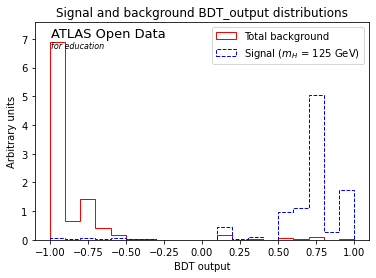

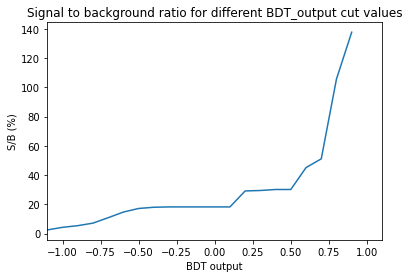

In [32]:
plot_SoverB(data)

# Neural Net using Keras

In [33]:
from keras.models import Sequential
from keras.layers import Dense

2022-06-26 18:57:03.456511: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.1-8d929/x86_64-centos7-gcc10-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.1-f3599/x86_64-centos7-gcc10-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/tensorflow/contrib/tensor_forest:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/tensorflow/python/framework:/cvmfs/sft.cern.ch/lcg/releases/java/8u222-884d8/x86_64-centos7-gcc10-opt/jre/lib/amd64:/cvm

In [34]:
# define the keras model
model = Sequential()
model.add(Dense(5, input_dim=X.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

2022-06-26 18:58:09.991411: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.1-8d929/x86_64-centos7-gcc10-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.1-f3599/x86_64-centos7-gcc10-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/tensorflow/contrib/tensor_forest:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/tensorflow/python/framework:/cvmfs/sft.cern.ch/lcg/releases/java/8u222-884d8/x86_64-centos7-gcc10-opt/jre/lib/amd64:/cvmfs/sft.cer

In [35]:
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [36]:
# fit the keras model on the dataset #epochs 5/10 batch 10
model.fit(X_train, y_train, epochs=10, batch_size=32)

2022-06-26 18:58:10.193600: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-26 18:58:10.195971: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2194915000 Hz


Epoch 1/10
8390/8390 [==============================] - 14s 2ms/step - loss: 0.6911 - accuracy: 0.7826
Epoch 2/10
8390/8390 [==============================] - 13s 2ms/step - loss: 0.4423 - accuracy: 0.8308
Epoch 3/10
8390/8390 [==============================] - 13s 2ms/step - loss: 0.3921 - accuracy: 0.8472
Epoch 4/10
8390/8390 [==============================] - 13s 2ms/step - loss: 0.2457 - accuracy: 0.9047
Epoch 5/10
8390/8390 [==============================] - 13s 2ms/step - loss: 0.1504 - accuracy: 0.9607
Epoch 6/10
8390/8390 [==============================] - 13s 2ms/step - loss: 0.1377 - accuracy: 0.9632
Epoch 7/10
8390/8390 [==============================] - 12s 1ms/step - loss: 0.1371 - accuracy: 0.9636
Epoch 8/10
8390/8390 [==============================] - 13s 2ms/step - loss: 0.1371 - accuracy: 0.9636
Epoch 9/10
8390/8390 [==============================] - 15s 2ms/step - loss: 0.1359 - accuracy: 0.9634
Epoch 10/10
8390/8390 [==============================] - 14s 2ms/step - l

In [37]:
# evaluate the keras model
_, accuracy = model.evaluate(X_train, y_train)
print('Accuracy: %.2f' % (accuracy*100))

8390/8390 [==============================] - 10s 1ms/step - loss: 0.1463 - accuracy: 0.9583
Accuracy: 95.83


In [38]:
y_predicted_keras = model.predict(X_test)

In [39]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

In [40]:
auc_keras = auc(fpr_keras, tpr_keras)

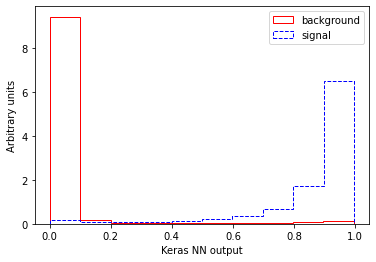

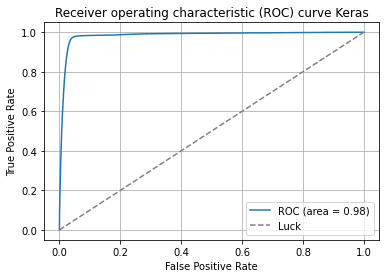

In [41]:
# we first plot the Neural Network output
signal_decisions = model.predict(X[y>0.5]).ravel() # get probabilities on signal
background_decisions = model.predict(X[y<0.5]).ravel() # get decisions on background

plt.hist(background_decisions, color='red', label='background', 
         histtype='step', # lineplot that's unfilled
         density=True ) # normalize to form a probability density
plt.hist(signal_decisions, color='blue', label='signal', 
         histtype='step', # lineplot that's unfilled
         density=True, # normalize to form a probability density
         linestyle='--' ) # dashed line
plt.xlabel('Keras NN output') # add x-axis label
plt.ylabel('Arbitrary units') # add y-axis label
plt.legend() # add legend
plt.savefig('plots/HZZ_Keras_distribution.pdf')


# we then plot the ROC
plt.figure() # make new figure 

from sklearn.metrics import roc_curve, auc

y_pred_keras = model.predict(X_test).ravel() # get probabilities on test set


# Compute ROC curve and area under the curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras) 

# Compute area under the curve for training set
roc_auc = auc(fpr_keras, # false positive rate 
              tpr_keras) # true positive rate

plt.plot(fpr_keras, tpr_keras, label='ROC (area = %0.2f)'%(roc_auc)) # plot test ROC curve
plt.plot([0, 1], # x from 0 to 1
         [0, 1], # y from 0 to 1
         '--', # dashed line
         color='grey', label='Luck')

plt.xlabel('False Positive Rate') # x-axis label
plt.ylabel('True Positive Rate') # y-axis label
plt.title('Receiver operating characteristic (ROC) curve Keras') # title
plt.legend() # add legend
plt.grid() # add grid
plt.savefig('plots/HZZ_ROC_Keras.pdf')

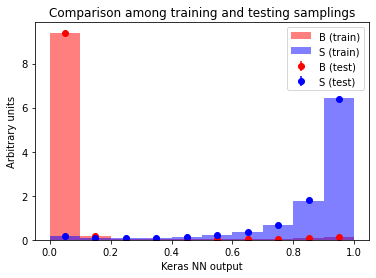

In [42]:
def compare_train_test(clf, X_train, y_train, X_test, y_test):
    decisions = [] # list to hold decisions of classifier
    for X,y in ((X_train, y_train), (X_test, y_test)): # train and test
        d1 = clf.predict(X[y<0.5]).ravel() # background
        d2 = clf.predict(X[y>0.5]).ravel() # signal
        decisions += [d1, d2] # add to list of classifier decision
    
    highest_decision = max(np.max(d) for d in decisions) # get maximum score
    bin_edges = [] # list to hold bin edges
    bin_edge = -0.1 # start counter for bin_edges
    while bin_edge < highest_decision: # up to highest score
        bin_edge += 0.1 # increment
        bin_edges.append(bin_edge)
    
    plt.hist(decisions[0], # background in train set
             bins=bin_edges, # lower and upper range of the bins
             density=True, # area under the histogram will sum to 1
             histtype='stepfilled', # lineplot that's filled
             color='red', label='B (train)', # Background (train)
            alpha=0.5 ) # half transparency
    plt.hist(decisions[1], # background in train set
             bins=bin_edges, # lower and upper range of the bins
             density=True, # area under the histogram will sum to 1
             histtype='stepfilled', # lineplot that's filled
             color='blue', label='S (train)', # Signal (train)
            alpha=0.5 ) # half transparency

    hist_background, bin_edges = np.histogram(decisions[2], # background test
                                              bins=bin_edges, # number of bins in function definition
                                              density=True ) # area under the histogram will sum to 1
    
    scale = len(decisions[2]) / sum(hist_background) # between raw and normalised
    err_background = np.sqrt(hist_background * scale) / scale # error on test background

    width = 0.1 # histogram bin width
    center = (bin_edges[:-1] + bin_edges[1:]) / 2 # bin centres
    
    plt.errorbar(x=center, y=hist_background, yerr=err_background, fmt='o', # circles
                 c='red', label='B (test)' ) # Background (test)
    
    hist_signal, bin_edges = np.histogram(decisions[3], # siganl test
                                          bins=bin_edges, # number of bins in function definition
                                          density=True ) # area under the histogram will sum to 1
    scale = len(decisions[3]) / sum(hist_signal) # between raw and normalised
    err_signal = np.sqrt(hist_signal * scale) / scale # error on test background
    
    plt.errorbar(x=center, y=hist_signal, yerr=err_signal, fmt='o', # circles
                 c='blue', label='S (test)' ) # Signal (test)
    
    plt.xlabel("Keras NN output") # write x-axis label
    plt.ylabel("Arbitrary units") # write y-axis label
    plt.legend() # add legend
    plt.title("Comparison among training and testing samplings")
    plt.savefig('plots/HZZ_Keras_compare_train_test.pdf')

    
compare_train_test(model, X_train, y_train, X_test, y_test) # call compare_train_test

In [43]:
# X only has only the MC features
y_predicted_keras = model.predict(X) 
y_predicted_keras

array([[0.9526279 ],
       [0.01098001],
       [0.00589779],
       ...,
       [0.08255634],
       [0.19478884],
       [0.5675653 ]], dtype=float32)

In [44]:
cumulative_events = 0 # start counter for total number of events for which output is saved
for key in data: # loop over samples
    if key!='data':
        data[key]['Keras_NN_output'] = y_predicted_keras[cumulative_events:cumulative_events+len(data[key])]
        cumulative_events += len(data[key]) # increment counter for total number of events
        print(data[key]['Keras_NN_output']) # print the dataframe column BDT_output

0      0.952628
1      0.010980
2      0.005898
3      0.011670
4      0.495545
         ...   
829    0.005811
830    0.047263
831    0.003371
832    0.004161
833    0.008040
Name: Keras_NN_output, Length: 834, dtype: float32
0         0.005288
1         0.043277
2         0.002546
3         0.364906
4         0.000012
            ...   
523952    0.003372
523953    0.003265
523954    0.002033
523955    0.012802
523956    0.820306
Name: Keras_NN_output, Length: 523957, dtype: float32
0         0.956589
1         0.789437
2         0.860120
3         0.968404
4         0.983317
            ...   
370035    0.957560
370036    0.972700
370037    0.082556
370038    0.194789
370039    0.567565
Name: Keras_NN_output, Length: 370040, dtype: float32


In [45]:
bin_width = 0.1
max_keras = y_predicted_keras.max()+bin_width
min_keras = y_predicted_keras.min()-bin_width
num_bins = np.ceil((max_keras - min_keras)/bin_width)
num_bins = num_bins.astype(int)
print("The max and min value of the BDT output for the y_predicted is {:.2f} and {:.2f}, {:.2f} respectively".format(
    max_keras, min_keras, num_bins))

The max and min value of the BDT output for the y_predicted is 1.10 and -0.10, 12.00 respectively


In [46]:
Keras_output = { # dictionary containing plotting parameters for the mllll histogram
    # change plotting parameters
    'bin_width':bin_width, # width of each histogram bin
    'num_bins':num_bins, # number of histogram bins
    'xrange_min':min_keras, # minimum on x-axis
    'xlabel':'Keras NN output' # x-axis label
}

SoverB_hist_dict = {'Keras_NN_output':Keras_output}

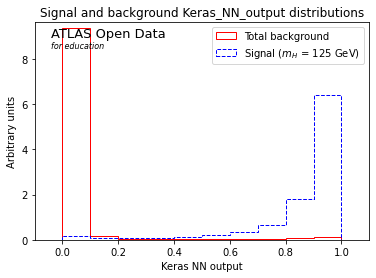

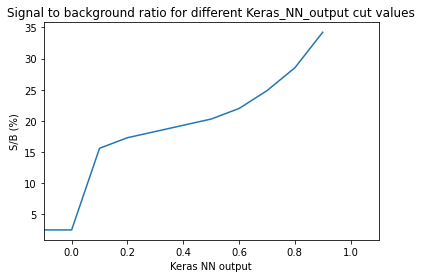

In [47]:
plot_SoverB(data)

In [48]:
def plot_data_optimized(data, model):
    GeV = 1
    xmin = 80 * GeV
    xmax = 250 * GeV
    step_size = 5 * GeV

    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    signal_x = data[r'Signal ($m_H$ = 125 GeV)']['mllll'] # histogram the signal
    signal_weights = data[r'Signal ($m_H$ = 125 GeV)'].totalWeight # get the weights of the signal events
    signal_color = samples[r'Signal ($m_H$ = 125 GeV)']['color'] # get the colour for the signal bar

    mc_x = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

    for s in samples: # loop over samples
        if s not in ['data', r'Signal ($m_H$ = 125 GeV)']: # if not data nor signal
            mc_x.append( data[s]['mllll'] ) # append to the list of Monte Carlo histogram entries
            mc_weights.append( data[s].totalWeight ) # append to the list of Monte Carlo weights
            mc_colors.append( samples[s]['color'] ) # append to the list of Monte Carlo bar colors
            mc_labels.append( s ) # append to the list of Monte Carlo legend labels
    


    # *************
    # Main plot 
    # *************
    main_axes = plt.gca() # get current axes
    
    # plot the Monte Carlo bars
    mc_heights = main_axes.hist(mc_x, bins=bin_edges, 
                                weights=mc_weights, stacked=True, 
                                color=mc_colors, label=mc_labels )
    
    mc_x_tot = mc_heights[0][-1] # stacked background MC y-axis value
    
    # calculate MC statistical uncertainty: sqrt(sum w^2)
    mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])
    
    # plot the signal bar
    main_axes.hist(signal_x, bins=bin_edges, bottom=mc_x_tot, 
                   weights=signal_weights, color=signal_color,
                   label=r'Signal ($m_H$ = 125 GeV)')
    
    # plot the statistical uncertainty
    main_axes.bar(bin_centres, # x
                  2*mc_x_err, # heights
                  alpha=0.5, # half transparency
                  bottom=mc_x_tot-mc_x_err, color='none', 
                  hatch="////", width=step_size, label='Stat. Unc.' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=True, # draw ticks on the top axis
                          right=True ) # draw ticks on right axis
    
    # x-axis label
    main_axes.set_xlabel(r'4-lepton invariant mass $\mathrm{m_{4l}}$ [GeV]',
                        fontsize=13, x=1, horizontalalignment='right' )
    
    # write y-axis label for main axes
    main_axes.set_ylabel('Events / '+str(step_size)+' GeV',
                         y=1, horizontalalignment='right') 
    
    # set y-axis limits for main axes
    main_axes.set_ylim( bottom=0, top=35 ) #---------------------------
    
    # add minor ticks on y-axis for main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 

    if(model == 'keras'):
        plt.title(r'$\mathrm{m_{4l}}$ invariant mass after cut on Keras output') # title

    if(model == 'BDT'):
        plt.title(r'$\mathrm{m_{4l}}$ invariant mass after cut on BDT output') # title
        
    # Add text 'ATLAS Open Data' on plot
    plt.text(0.05, # x
             0.93, # y
             'ATLAS Open Data', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 
    
    # Add text 'for education' on plot
    plt.text(0.05, # x
             0.88, # y
             'for education', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=8 ) 
    
    # Add energy and luminosity
    lumi_used = str(lumi*fraction) # luminosity to write on the plot
    plt.text(0.05, # x
             0.82, # y
             '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes
    
    # Add a label for the analysis carried out
    plt.text(0.05, # x
             0.76, # y
             r'$H \rightarrow ZZ^* \rightarrow 4\ell$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # draw the legend
    main_axes.legend( frameon=False ) # no box around the legend
    plt.savefig('plots/HZZ_m4L_optimized'+model+'.pdf')
    return

In [51]:
#data_BDT = {}
#data_keras = {}
data_BDT = data.copy()
data_keras = data.copy()
#del data_BDT['data']
#del data_keras['data']

In [53]:
data_keras['data']

,lep_charge,lep_type,lep_pt,lep_eta,lep_phi,lep_E,mcWeight,scaleFactor_PILEUP,scaleFactor_ELE,scaleFactor_MUON,scaleFactor_LepTRIGGER,mllll,lep_pt_1,lep_pt_2
0,"[-1, 1, -1, 1]","[11, 13, 13, 11]","[175558.73, 138846.67, 106696.53, 79776.73]","[2.076854, 0.9641987, 0.4538123, 2.3985784]","[1.2929627, -2.2561386, -1.7970102, 0.5870669]","[711421.06, 208545.92, 117873.27, 442695.56]",0.0,0.0,0.0,0.0,0.0,649.271931,175.558734,138.846672
1,"[-1, 1, -1, 1]","[11, 11, 13, 13]","[65284.066, 37290.766, 12426.926, 8804.564]","[0.103151694, 0.43131045, 0.98646265, 1.1151001]","[2.3295352, -2.4817212, 2.2234292, 2.4967396]","[65631.695, 40813.45, 18980.092, 14870.211]",0.0,0.0,0.0,0.0,0.0,87.907098,65.284066,37.290766
2,"[1, 1, -1, -1]","[11, 11, 11, 11]","[146784.7, 127539.97, 33562.18, 29776.129]","[-0.20137234, -0.26222968, -0.2997417, 0.47760...","[0.56058794, -2.2311037, 2.0015476, 2.9714534]","[149770.89, 131950.27, 35081.2, 33237.22]",0.0,0.0,0.0,0.0,0.0,344.775936,146.784703,127.539969
3,"[-1, -1, 1, 1]","[13, 11, 11, 13]","[135680.69, 82894.8, 62508.098, 42552.906]","[1.4913375, 0.73802865, 1.2436671, 0.5755266]","[-0.7563026, -2.7576957, 2.2719328, -1.1226101]","[316685.9, 106514.14, 117410.016, 49797.125]",0.0,0.0,0.0,0.0,0.0,326.583790,135.680688,82.894797
4,"[1, -1, -1, 1]","[11, 11, 13, 13]","[67713.18, 42791.816, 12742.542, 10291.093]","[-1.5264179, -0.06150811, -0.6896634, -0.6163658]","[-1.4037814, -1.353487, -0.32475498, -0.3771284]","[163154.1, 42872.79, 15895.331, 12309.051]",0.0,0.0,0.0,0.0,0.0,107.422585,67.713180,42.791816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,"[-1, 1, 1, -1]","[11, 11, 11, 11]","[51773.375, 51708.45, 51148.297, 30737.582]","[-1.28635, -1.0202633, -0.80568916, 0.30312154]","[1.1772112, -1.047273, -1.4184802, 2.3813634]","[100850.09, 81038.13, 68667.06, 32160.553]",0.0,0.0,0.0,0.0,0.0,209.585334,51.773375,51.708449
503,"[1, -1, -1, 1]","[13, 13, 13, 13]","[61561.816, 25231.277, 21982.31, 14411.031]","[-0.6561884, -0.043175437, 0.49340436, -0.2145...","[3.0332172, 1.3050667, 0.06840056, 2.7004883]","[75298.086, 25255.02, 24713.037, 14744.3125]",0.0,0.0,0.0,0.0,0.0,121.270402,61.561816,25.231277
504,"[-1, 1, 1, -1]","[13, 13, 13, 13]","[53048.145, 39838.145, 23835.697, 7428.501]","[1.6669953, 1.2820495, 0.009336205, 1.5172257]","[1.6207898, -1.2548615, -2.9835243, -0.25539052]","[145485.73, 77315.69, 23836.97, 17750.264]",0.0,0.0,0.0,0.0,0.0,149.033446,53.048145,39.838145
505,"[1, 1, -1, -1]","[11, 11, 11, 11]","[114072.234, 113360.6, 64472.6, 26180.354]","[1.6677951, 1.1956723, 1.5933089, 1.2851827]","[0.0551456, 3.0626664, -0.9325686, -1.999637]","[313078.7, 204518.39, 165154.75, 50946.03]",0.0,0.0,0.0,0.0,0.0,318.595413,114.072234,113.360602


In [68]:
data_keras_optimized_params = {}
inputs = ['mllll', 'lep_pt_1'] # list of features for BDT
data_keras_optimized_params['data'] = data_keras['data'][inputs].copy()
temp_keras = []
temp_keras.append(data_keras_optimized_params['data'])
X_data_keras = np.concatenate(temp_keras) # concatenate the list of MC dataframes into a single 2D array of features, called X

data_keras_predicted = model.predict(X_data_keras)
data_keras['data']['Keras_NN_output'] = data_keras_predicted[0:0+len(data_keras['data'])]
"""
for key in data_keras: # loop over samples
    if key!='data':
        fail_keras_ouput = data_keras[key][data_keras[key]['Keras_NN_output'] <= 0.65].index
        data_keras[key].drop(fail_keras_ouput,inplace=True) # drop the events that don't fulfill with sum_dphi < 3.5 requirement
        data_keras[key] = data_keras[key].reset_index(drop=True)
        
"""
#data_keras_optimized_params
#temp_keras
#X_data_keras
#data_keras_predicted
print(data_keras['data']['Keras_NN_output'])

0      0.000006
1      0.034729
2      0.001508
3      0.001839
4      0.586795
         ...   
502    0.006578
503    0.947823
504    0.012726
505    0.002004
506    0.002297
Name: Keras_NN_output, Length: 507, dtype: float32


In [69]:
for key in data_keras: # loop over samples
    fail_keras_ouput = data_keras[key][data_keras[key]['Keras_NN_output'] <= 0.65].index
    data_keras[key].drop(fail_keras_ouput,inplace=True) # drop the events that don't fulfill with sum_dphi < 3.5 requirement
    data_keras[key] = data_keras[key].reset_index(drop=True)

In [50]:
for key in data_keras: # loop over samples
    if key!='data':
        fail_keras_ouput = data_keras[key][data_keras[key]['Keras_NN_output'] <= 0.65].index
        data_keras[key].drop(fail_keras_ouput,inplace=True) # drop the events that don't fulfill with sum_dphi < 3.5 requirement
        data_keras[key] = data_keras[key].reset_index(drop=True)

In [51]:
for key in data_BDT: # loop over samples
    if key!='data':
        fail_BDT_ouput = data_BDT[key][data_BDT[key]['BDT_output'] <= 0.125].index
        data_BDT[key].drop(fail_BDT_ouput,inplace=True) # drop the events that don't fulfill with sum_dphi < 3.5 requirement
        data_BDT[key] = data_BDT[key].reset_index(drop=True)

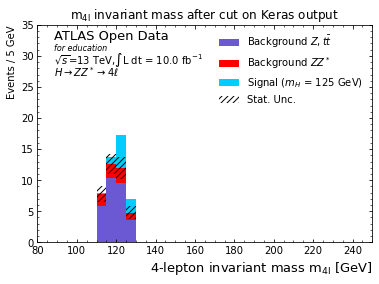

In [70]:
plot_data_optimized(data_keras, 'keras')

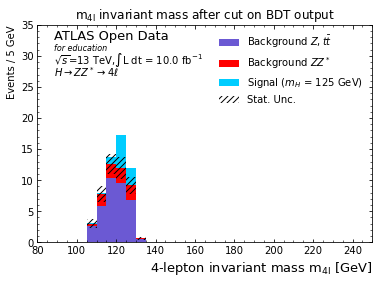

In [53]:
plot_data_optimized(data_BDT, 'BDT')